<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Перед нами исторические данные о заказах такси в аэропортах.Нам необходимо спрогнозировать количество заказов такси на следующий час. Для этого построим модель.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

Подключим необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
import warnings
from lightgbm import LGBMRegressor

In [2]:
# команда для игнорирования предупреждений
warnings.filterwarnings('ignore')

In [3]:
# заранее определим стиль для наших графиков
plt.style.use('ggplot')

Загрузим и изучим данные.

In [37]:
# установим индекс таблицы равным столбцу datatime
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [38]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [39]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


Проверим, , в хронологическом ли порядке расположены даты и время.

In [40]:
data.index.is_monotonic

True

Перед нами данные за пол года с 01.03.2018 по 31.08.2018. Они расположены в хронологическом порядке.
Выполним ресемплирование суммарных данных за один час и построим график временного ряда.

In [41]:
data = data.resample('1H').sum()

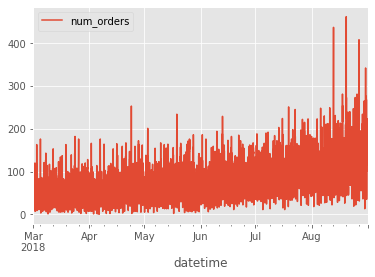

In [42]:
data.plot()

### Вывод

Пока ничего не понятно, можно лишь сказать, что количество со временем ратёт. Далее перейдём к анализу данных. 

## Анализ

В этой части проекта проанализируем наши данные. Посмотрим какие тренды и сезонности можно найти в наших данных. 

Так как нам необходимо спрогнозировать количество заказов такси на следующий час, выбелим данные за о заказах за последнюю неделю.

In [10]:
data = data['2018-08-24' : '2018-08-31']

Добавим столбец со скользящее среднее и построим график количество заказов такси.

In [11]:
# добавим столбец со скользящим средним
data['rolling_mean'] = data.rolling(10).mean()

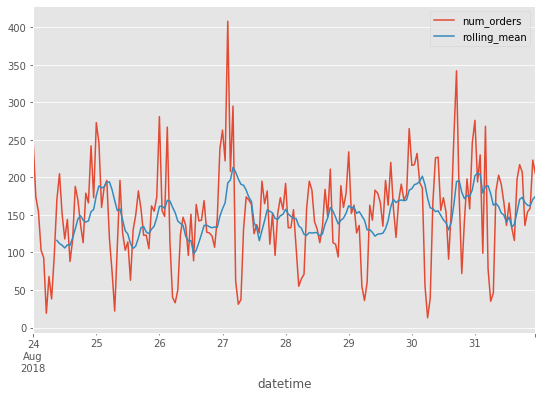

In [12]:
data.plot(figsize=(9, 6), grid=True)

Значения столбца 'rolling_mean' находятся в одном диапазоне, лишь наблюдается небольшой рост. Это говорит о том, что в среднем в каждый день количество заказов одно. 

Далее разложим временной ряд на тренд и сезонную компоненту. Построим графики этих составляющих ряда.

In [13]:
decomposed = seasonal_decompose(data['num_orders'])

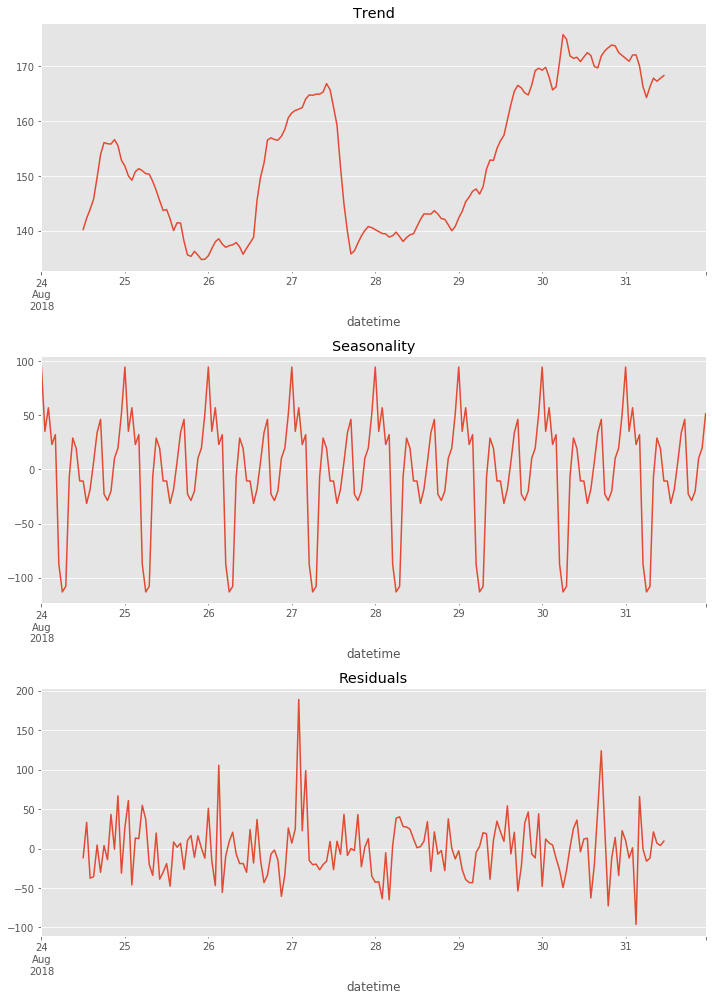

In [14]:
plt.figure(figsize=(10, 14))

plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')


plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca()) 
plt.title('Seasonality')


plt.subplot(313)
decomposed.resid.plot(ax=plt.gca()) 
plt.title('Residuals')
plt.tight_layout()

Сезонность с периодом в день, что логично. Заказов днем больше, чем ночных заказов.

Но наш ряд всё ещё не стационарный. Чтобы это исправить Вычислим разности временного ряда.

In [15]:
data = data - data.shift()
data['mean'] = data['num_orders'].rolling(15).mean()
data['std'] = data['num_orders'].rolling(15).std()

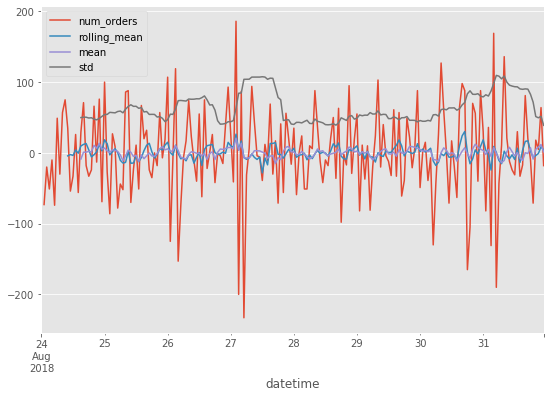

In [16]:
data.plot(figsize=(9, 6), grid=True)

### Вывод

Ряд стал более стационарный, а знасит, данные можно прогнозировать. Далее перейдём к подбору и обучению модели.

## Обучение

В этой части проекта займёмся обучением и поиском лучшей модели.

Разделим данные на тренировочную и тестовую. Сделаеv тестовую выборку размером 10% от исходных данных.

Обучим разные модели с различными гиперпараметрами и проверим их качество метрикой RMSE.

In [17]:
#удалим ненужные значения из данных
del data['mean'], data['std'], data['rolling_mean']

Перед тем, как добавлять признаки, проверим, есть ли у нас пропущенные значения.

In [18]:
data.isna().sum()

num_orders    1
dtype: int64

In [19]:
# удалим пропуски
data = data.dropna()
data.isna().sum()

num_orders    0
dtype: int64

С пропусками разобрались. Далее создадим признаки для горизонта прогнозирования в один шаг.

In [20]:
def make_features(data, max_lag, rolling_mean_size):
    
    #  Календарные признаки
    
    
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    # «Отстающие значения»
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    # Скользящее среднее
    data['rolling_mean'] =  data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [21]:
#make_features(data, 4*8, 10)

In [43]:
make_features(data, 4*8, 48)

In [44]:
# поделим наши выборки
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [45]:
print(train.index.min(), train.index.max(), train.shape)
print(test.index.min(), test.index.max(), test.shape)


2018-03-01 00:00:00 2018-08-13 13:00:00 (3974, 36)
2018-08-13 14:00:00 2018-08-31 23:00:00 (442, 36)


Данные разбили корректно: обучающая выборка заканчивается 31 августа в 3 часа, а тестовая начинается 31 августав в 4 часа.

Выделим целевой признак.

In [46]:
# из обучающей выборки удалим строки с пропусками
train = train.dropna()

In [47]:
features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']

Данные для обучения готовы. Обучим модели линейной регрессии и случайного леса и проверим значения метрики RMSE на тренировочной выборке.

In [48]:
model = LinearRegression().fit(features_train, target_train)
pred_train = model.predict(features_test)

print("RMSE =", mean_squared_error(target_test, pred_train)**0.5)

RMSE = 44.73843222108494


При помощи модели линейной регрессии удалось добиться значения метрики RMSE равному 48.3. 

Далее проверим, как покажет себя модель случайного леса.

In [27]:
model = RandomForestRegressor(random_state=30050).fit(features_train, target_train)
pred_train = model.predict(features_test)

print("RMSE =", mean_squared_error(target_test, pred_train)**0.5)

RMSE = 62.60228430337027


При помощи модели случайного леса удалось добиться значения метрики RMSE равному 62.6, немного хуже, чем у линейной регрессии. С помощью подборов гиперпараметров постараемся улучшить это значение.

In [28]:
best_results = 3000
estimator = 0

for n_estimators in [1, 5, 10, 50, 100, 500]:
    
    model = RandomForestRegressor(random_state=30050, n_estimators=n_estimators).fit(features_train, target_train)
    predictions = model.predict(features_test)
    rmse = mean_squared_error(target_test, predictions)**0.5
    
    if rmse < best_results:
        best_results = rmse
        estimator = n_estimators
        
print('Best model:')
print(f'n_estimators = {estimator}, RMSE = {best_results}')

Best model:
n_estimators = 50, RMSE = 59.59777915325368


Лучше всего себя показала модель с 50 деревьями.

In [29]:
best_results = 3000
best_depth = 0

for depth in [1, 10, 30, 50, 500]:
    
    model = RandomForestRegressor(random_state=30050, n_estimators=50, max_depth=depth).fit(features_train, target_train)
    pred = model.predict(features_test)
    rmse = mean_squared_error(target_test, pred)**0.5
    
    if rmse < best_results:
        best_results = rmse
        best_depth = depth
        
print('Best model:')
print(f'max_depth = {best_depth}, RMSE = {best_results}')

Best model:
max_depth = 10, RMSE = 59.12114320427387


Лучшее значение RMSE, которое мы смогли достичь с случайным лесом равно 59.1, это всеравно хуже линейной регрессии.

### Вывод

Подобрали модель. Лучше всего себя показала модель линейной регресии. В следующей и заключительной части нашего проекта протестируем нашу модель, проверим её на вменяемость.

## Тестирование

В этой части работы нам предстоит спрогнозировать временные ряды без обучения двумя способами:

* прогнозирование средним;
* прогнозирование предыдущим значением.

Рассчитаем значение метрики RMSE и сравним его с оценкой качества нашей модели.

In [49]:
model = LinearRegression().fit(features_train, target_train)
pred_test = model.predict(features_test)

print("RMSE нашей модели:", mean_squared_error(target_test, pred_test)**0.5)

RMSE нашей модели: 44.73843222108494


Рассчитаем значение метрики RMSE при прогнозировании средними значениями.

In [31]:
print("Средний объём электропотребления в день:", target_test.mean())

pred_median = np.ones(target_test.shape) * target_train.median()

print("RMSE прогнозирования средним:", mean_squared_error(target_test, pred_median)**0.5)

Средний объём электропотребления в день: 5.3
RMSE прогнозирования средним: 72.93764460139907


RMSE = 72.9, что больше, чем у нашией модели линейной регрессии.

Рассчитаем значение метрики RMSE при прогнозировании предыдущими значениями.

In [32]:
print("Средний объём электропотребления в день:", target_test.mean())

pred_previous = target_test.shift(fill_value=target_train.iloc[target_train.shape[0]-1])

print("RMSE:", mean_squared_error(target_test, pred_previous)**0.5)

Средний объём электропотребления в день: 5.3
RMSE: 126.04066804012108


RMSE у данного способа прогнащирования даже, больше чем у прошлой.

In [33]:
test['predictions'] = pred_test

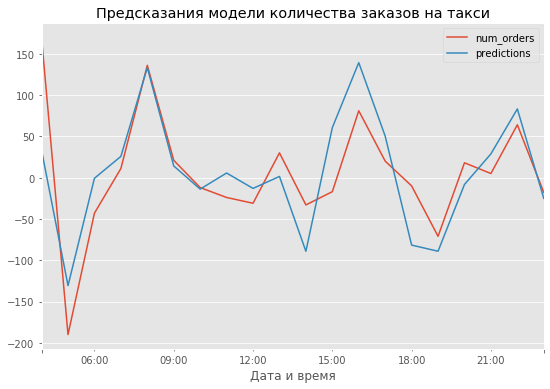

In [34]:
ax = test[['num_orders','predictions']].plot(figsize=(9, 6), grid=True)

ax.set_title('Предсказания модели количества заказов на такси')
ax.set_xlabel("Дата и время");

### Вывод

Наша модель прошла проверку на вменяемость. Её значение метрики RMSE меньше чем у моделей прогнозирующих без обучения.

## Вывод

В данной работе нам удалось построить модель для предсказания количества заказов такси на следующий час. Мы рассмотрели две модели: линейную регрессию и случайный лес. Оценивали мы их метрикой качества RMSE. Лучше всего себя показала модель линейной регрессии. В конце, чтобы убедится, что мы проделали нашу работу не зря, сравнили модель с моделями, которые предсказывают без обучения. У них значения метрики RMSE выше, что говорит о том, что наша модель вменяема.

Так что, подводя итоги, я бы предложил компании «Чётенькое такси» для прогнозирования спроса на следующий час использовать модель линейной регрессии.